# Soccer Mobile
<!-- Introduction of the project -->

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import time
import random

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

## Geometry

In [2]:
from geo import *

## Vision


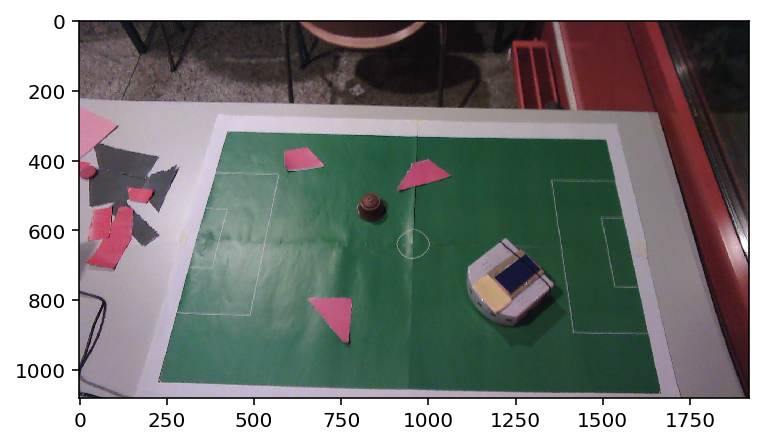

In [3]:
from vision import *
vision_processor = VisionProcessor()
img = cv2.imread("img/example.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

### Image Processing

#### Color Filtering

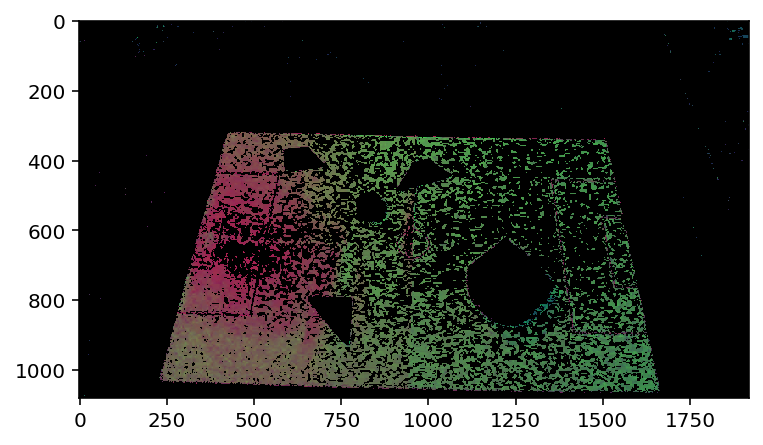

In [4]:
color = 'green'
green_mask = VisionProcessor.color_filter(img, color=color)
plt.imshow(cv2.cvtColor(green_mask, cv2.COLOR_RGB2BGR))

#### Corner Detection

##### 1. Using Image Processing

In [5]:
# 1. find the biggest green part

gray = cv2.cvtColor(green_mask, cv2.COLOR_BGR2GRAY)
(T, thresh) = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
# morphology operation against noise
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((10, 10)))
# extract contours
_,contours,hierarchy = cv2.findContours(closing,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Taking the one with the largest area # serve as the opening operation to some extent
c = max(contours, key = cv2.contourArea)
# use a convexHull against noise
hull = cv2.convexHull(c)
hull_img = np.zeros_like(img)     
length = len(hull)
for i in range(len(hull)):
    cv2.line(hull_img, tuple(hull[i][0]), tuple(hull[(i+1)%length][0]), (255,0,0), 2)
hull_img = cv2.cvtColor(hull_img, cv2.COLOR_RGB2GRAY)
plt.imshow(hull_img)    
_,convexcontour,_ = cv2.findContours(hull_img,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ch = img.copy()
cv2.drawContours(ch,convexcontour,-1,(255,0,0),1)
#plt.imshow(cv2.cvtColor(ch, cv2.COLOR_RGB2BGR))      

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# 2. get 4 corners
lines = VisionProcessor.divide4(np.array(hull))
ll = lines[np.argmax([abs(l[-1]) for l in lines])]
lines.remove(ll)
rl = lines[np.argmax([abs(l[-1]) for l in lines])]
lines.remove(rl)
ul = lines[0]
dl = lines[1]
corners = []
i = 1
ch = img.copy()
for h in [ul, dl]:
    for v in [ll, rl]:
        x, y = VisionProcessor.intersection(h[0], h[1], -h[2], v[0], v[1], -v[2])
        corners.append([x, y])
        print("corner",x, y)
        cv2.circle(ch, (x, y), 3, (0, 255, 0), -1)
        cv2.putText(ch,str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        i += 1
        
corners = np.array(corners)

plt.imshow(ch)


##### 2. Using aruco

In this part we get the pixel coordinates of all four corners by using the aruco markers.

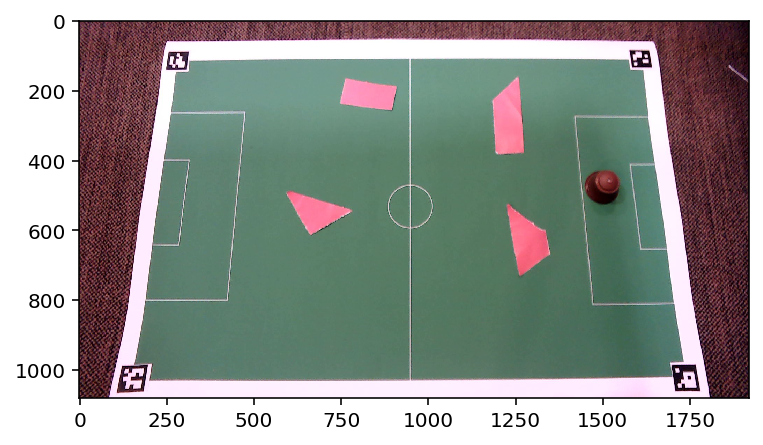

In [9]:
from vision import *
vision_processor = VisionProcessor()
img = cv2.imread("img/test.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

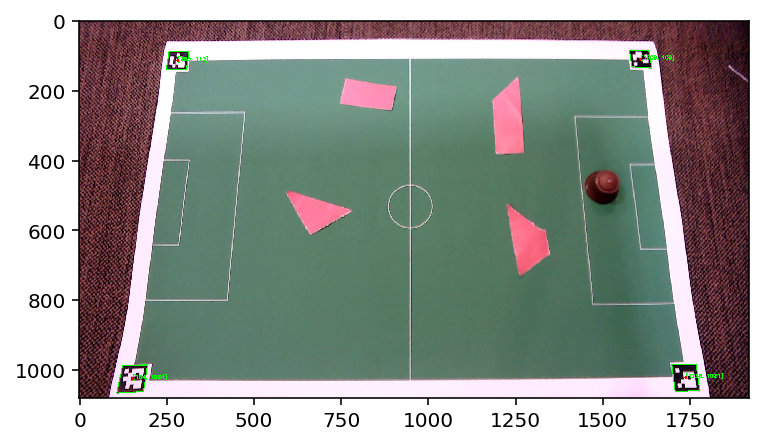

In [10]:
corners, a_image = vision_processor.visualize_aruco(img)
corners
plt.imshow(cv2.cvtColor(a_image, cv2.COLOR_RGB2BGR))

#### Perspective Projection
[TODO]

[array([283, 113]), array([ 154, 1024]), array([1738, 1021]), array([1609,  109])]


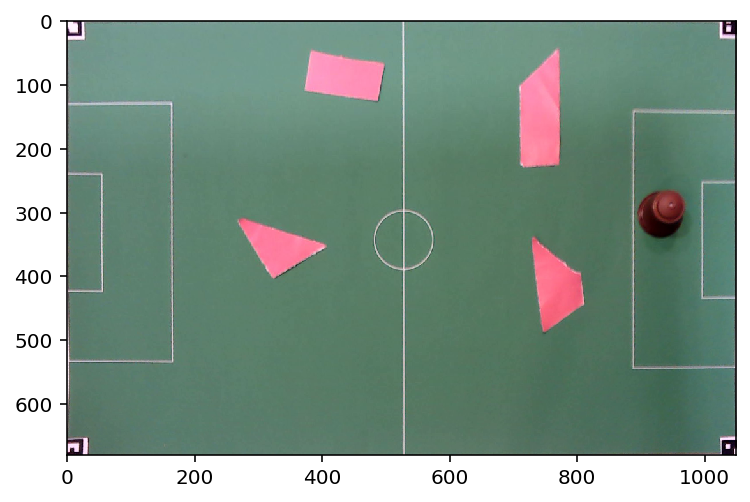

In [11]:
M = VisionProcessor.align_field(corners)
warped = VisionProcessor.warp(img, M)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))


In [ ]:
# import numpy as np
# import cv2

# cap = cv2.VideoCapture(3)

# # fourcc = cv2.VideoWriter_fourcc(*'XVID')
# # out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640,480))

# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret==True:
# #         frame = cv2.flip(frame,0)

#         image=resize_image(frame,80)
# #         image=align_field(image)
# #         out.write(frame)

#         cv2.imshow('frame',image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#     else:
#         break
# cap.release()

# # out.release()

# cv2.destroyAllWindows()

#### Box Detection

#### Ball Detection

### Detect Objects

#### The Field

#### The obstacles

#### The ball

#### Thymio

## Global Navigation
This module aims to plan a path from the start to the goal.
The result will be represented in form of a list of Waypoints.

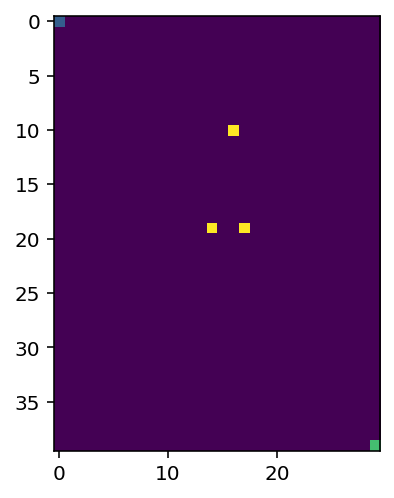

In [12]:
###
h, w = 40, 30
pStart = Pos(0,0)
pBall = Pos(h-1, w-1)
rmap = GridMap(h, w, 0.01)
rmap.set_start(pStart)
obslist = [Pos(random.randint(10,h-11),random.randint(10,w-11)) for _ in range(3)]
rmap.set_obs(obslist)

Goal_state = State(Pos(h-1,w-1), 1.57)
###

obsmap = [[int(val) for val in li] for li in rmap.obs_map]
obsmap[pStart.x][pStart.y] = 0.3
obsmap[pBall.x][pBall.y] = 0.7
plt.imshow(obsmap)

### Pre-Processing
#### Enlarge the obstacles
After getting the environment map, we need to enlarge the obstacles to make sure every point is safe for thymio.

In [ ]:
from global_navigation import *
planner =  PathPlanner(rmap, path_simplification=False)
plt.imshow(planner.obs) # has auto enlarged the obs when load the map

#### Caculate the actual position
The goal position represent where that the head of thmio will reach; We need to calculate the actual center position of thymio for the goal.

In [ ]:
pGoal1 = planner.approach(pBall)
planner.set_goal(pGoal1)
print("Goal State:",pGoal1)
import copy
obs = copy.deepcopy(planner.obs)
obs[pStart.x][pStart.y] = 0.3
obs[pBall.x][pBall.y] = 0.7
obs[pGoal1.pos.x][pGoal1.pos.y] = 0.5
plt.imshow(obs)

### Path Planning
We implemented two ways of path planning, namely, A* and RRT.
A* is an optimal path planning algorithm.
RRT is usually applied for high-dimension path planning. For our project, if we get a quite large grid map, the computational cost will be high, and RRT can boost up the speed. We should note that, it's not a optimal algorithms.

In [ ]:
# the result of A*
# points in the same direction have been deleted
planner.method = "A*"
planner.neighbor = 8
apath = planner.plan()
nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

In [ ]:
# the result of RRT
planner.method = "RRT"
rrtpath = planner.plan()
nobs = copy.deepcopy(obs)
for p in rrtpath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

### Post-Processing
#### Collect waypoints in same direction
The waypoints in same direction just have the same effect for path tracking, so we try to elimate some redandent points.

In [ ]:
apath = planner.collect_wps(apath)
nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

#### Shrink the waypoints
Try to connect the grandparent to grandchild directly.

In [ ]:
apath = planner.path_simplification(apath)
nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

#### Assign Orientation


In [ ]:
Global_path = planner.assign_ori(apath)
for s in Global_path:
    print(s)

## Local Navigation


## Filtering
### Overview
The goal of the filtering module is to integrate (if available) the measurements (in our case, the vision output) with the information from the motor encoders to estimate a reasonable state for Thymio. To this end, we use Extended Kalman Filter (EKF) technique in our project. Compared to the regular Kalman Filter, Extended Kalman Filter is the nonlinear version of the Kalman filter which utilizes first (or second) order derivative to do the approximation.

## Robot States

The state of Thymio is represented as $$\mu_t = [x_t, y_t, \theta_t]^T$$ as shown in the figure below, corresponding to the x, y, and orientation of the robot as shown in the figure below.
<center><img src="Notebook_figures/robot_state.png" alt="" style="width: 800px;"/></center>
Where we denote the displacement in distance as D and displacement in orientation as T (for the sake of simplicity we omit the indices).

## State Space Representation of EKF
### Action and Measurement Model
The action and measurement model of EKF is shown below, where $f$ and $h$ are two nonlinear functions.
\begin{array}{l}\boldsymbol{x}_{t}=f\left(\boldsymbol{x}_{t-1}, \boldsymbol{u}_{t}\right)+\boldsymbol{w}_{t} \\\boldsymbol{z}_{t}=h\left(\boldsymbol{x}_{t}\right)+\boldsymbol{v}_{t}\end{array}

The prediction stage of EKF is described as:
$$\hat{\boldsymbol{x}}_{t \mid t-1}=f\left(\hat{\boldsymbol{x}}_{t-1 \mid t-1}, \boldsymbol{u}_{t}\right)$$


where the input of the system is a vector consisting of two encoder displacements of Thymio left/right wheels represented as $u_t = [\Delta S_r,\Delta S_l ]^T$
<center><img src="Notebook_figures/turning.png" alt="" style="width: 300px;"/></center>

In [ ]:
import filtering
# Motor Calibration

In [ ]:
pre_state = np.array([0.0, 0.0, 0]).reshape(-1, 1) # initial state
pre_cov = np.ones([3, 3]) * 0.03 # initial covariance
G_filter = filtering.KF(pre_state, pre_cov, qx=0.1, qy=0.1, qtheta=0.3, rl=0.1, rr=0.1, b=0.0927)
G_filter.timer = time.time()

In [ ]:
G_filter.states

## Motion Control
Actuator.

In [ ]:
from Thymio import Thymio
import motion_control

THYMIO_PORT = "COM6"
THYMIO_REFRESH_RATE = 1.0
G_verbose = True
S_camera_interval = 1000 #ms
S_motion_interval = 10 #ms
S_track_interval = 0.1 #s

S_epsilon_dis = 0.005
S_epsilon_theta = 0.1

G_mc = motion_control.MotionController(
    Thymio.serial(port=THYMIO_PORT, refreshing_rate=THYMIO_REFRESH_RATE), 
    S_motion_interval, eps_delta_r=S_epsilon_dis, eps_delta_theta=S_epsilon_theta, 
    max_speed=100,
    verbose=G_verbose)

In [ ]:
#G_camera_timer = time.time()
G_track_timer = time.time()
G_mc.get_displacement()

def localizate():
    """Track Where Thymio is"""
    global G_camera_timer
    starter = G_filter.timer
    # 3. Localization 
    # 3.1 odometer
    dsl, dsr = G_mc.get_displacement()
    # 3.2 With Vision
        # if starter - G_camera_timer > S_camera_interval:
        #     vision_thymio_state = G_vision._getThymio()
        #     # Vision Failed
        #     if vision_thymio_state is None:
        #         G_filter.kalman_filter(dsr, dsl)
        #     else:
        #         G_camera_timer = starter
        #         G_filter.kalman_filter(dsr, dsl, vision_thymio_state)
        # else:        
        #     G_filter.kalman_filter(dsr, dsl)
    G_filter.kalman_filter(dsr, dsl)
    thymio_state = G_filter.get_state()
    return thymio_state

print(localizate())

In [ ]:
def reset():
    G_filter.states = [np.array([0.0, 0.0, 0]).reshape(-1, 1)] # initial state
    G_filter.covs = [np.ones([3, 3]) * 0.03]    
    G_track_timer = time.time()
    G_mc.get_displacement()
    print(localizate())
   
reset() 
## Fake Waypoints
Global_path = [State(Pos(0.1,0.0),0), State(Pos(0.1, 0.1),0.0),State(Pos(0.15, 0.15),0.0), State(Pos(0.2,0.2),0)]
Goal_state = Global_path[-1]

In [ ]:
G_mc.stop()

In [ ]:
for s in Global_path:
    print(s)
print("Goal",Goal_state)

In [ ]:
debug_timer = 0.0
while True:
    starter = time.time()
    # 3. Localization
    Thymio_state = localizate()
    # 2.2.1 Finished?
    if Thymio_state.dis(Goal_state) < S_epsilon_dis \
        and abs(Thymio_state.ori - Goal_state.ori) < S_epsilon_theta:
        G_mc.stop()
        if G_verbose:
            print("Terminate Reached!")
        break
    # 2.2.2 Is there obstacles on the front?
    # if G_mc.obs_front():
    #     G_mc.avoid() # do local navigation for, like, 10ms
    #     # TODO: replan
    # else:
    if starter - G_track_timer > S_track_interval:
        # 4. Follow the path    # <-- The only task can run under low frequency
        reached = G_mc.path_tracking(Global_path[0], Thymio_state, len(Global_path) == 1)
        if reached:
            print(Global_path[0],"reached")
            Global_path = Global_path[1:]
            # assume Global_path is not empty because of 2.2.1
        G_track_timer = starter
    loop_time = time.time() - starter
    if starter - debug_timer > S_track_interval:
        debug_timer = starter
        print(F"thymio: {Thymio_state}")

End of the test

In [ ]:

G_camera_timer = time.time()
G_track_timer = time.time()

def localizate():
    """Track Where Thymio is"""
    global G_camera_timer
    starter = G_filter.timer
    # 3. Localization 
    # 3.1 odometer
    dsl, dsr = G_mc.get_displacement()
    # 3.2 With Vision
    # if starter - G_camera_timer > S_camera_interval:
    #     vision_thymio_state = G_vision._getThymio()
    #     # Vision Failed
    #     if vision_thymio_state is None:
    #         G_filter.kalman_filter(dsr, dsl)
    #     else:
    #         G_camera_timer = starter
    #         G_filter.kalman_filter(dsr, dsl, vision_thymio_state)
    # else:        
    G_filter.kalman_filter(dsr, dsl)
    
    thymio_state = G_filter.get_state()
    return thymio_state


In [ ]:
Global_path = planner.assign_ori(apath)
for s in Global_path:
    print(s)

In [ ]:
G_mc.stop()

In [ ]:
debug_timer = time.time()
print(localizate())
while True:
    starter = time.time()
    # 3. Localization
    Thymio_state = localizate()
    # 2.2.1 Finished?
    if Thymio_state.dis(Goal_state) < S_epsilon_dis \
        and abs(Thymio_state.ori - Goal_state.ori) < S_epsilon_theta:
        if G_verbose:
            print("Terminate Reached!")
        break
    # 2.2.2 Is there obstacles on the front?
    if G_mc.obs_front():
        G_mc.avoid() # do local navigation for, like, 10ms
        # TODO: replan
    else:
        if starter - G_track_timer > S_track_interval:
            # 4. Follow the path    # <-- The only task can run under low frequency
            reached = G_mc.path_tracking(Global_path[0], Thymio_state, len(Global_path) == 1)
            if reached:
                Global_path = Global_path[1:]
                # assume Global_path is not empty because of 2.2.1
            G_track_timer = starter
    loop_time = time.time() - starter
    # TODO: how long does it takes? -- about 1ms
    #       then, which motor speed fit the period time
    #             should we stop to calibrate pose?

    if starter - debug_timer > 1.0:
        print(Thymio_state)
        debug_timer = starter
    #if G_verbose:
    #    print(F"looper time: {loop_time*1000 :.0f}ms")


In [ ]:
get_ball = False
# 1. get the ball
planner.set_goal = pBall
planner.set_start = None # Pos of Thymio [Filtering]
waypoints = planner.plan()
while not get_ball:
    if controller.obs_forward():
        pass #   [Local Navigation]
        #          return to waypoints to follow
    else:
        waypoints = controller.go_pos(waypoints) # follow the waypoints 
    pass

# 2. Push the ball to the goal
finished = False
planner.set_goal = pGoal
planner.set_start = None # Pos of Thymio [Filtering]
waypoints = planner.plan()
while not finished:
    if controller.obs_forward():
        pass #   [Local Navigation]
        #          return to waypoints to follow
    else:
        waypoints = controller.go_pos(waypoints) # follow the waypoints 
    pass

# Serial Control vs TDMClient

In [ ]:
from Thymio import Thymio
import os
import sys

In [ ]:
!pip install pyserial

In [ ]:
import sys
import glob
import serial


def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


if __name__ == '__main__':
    print(serial_ports())

In [ ]:
sys.setrecursionlimit(3000)
print(os.getenv('COM4'))

In [ ]:
th = Thymio.serial(port=os.getenv('COM6'), refreshing_rate=0.1)